In [3]:
import IsingEasing
import numpy as np
import pandas as pd
import multiprocessing as mp
import os
import time

In [4]:
help(IsingEasing)

Help on package IsingEasing:

NAME
    IsingEasing

DESCRIPTION
    IsingEasing
    =====
    
    Simple Ising model simulation on a squared lattice with the Metropolis algorithm.
    
    Available subpackages
    ---------------------
    
    IsingEasing.Ising
        Base Class.
        Standard Metropolis implementation of Ising model on squared lattice
    
    IsingEasing.IsingC
        Subclass of IsingEasing.Ising where IsingEasing.IsingC.update() call the static library 'IsingEasing.IsingC.so' to performe the Metropolis update.
    
    IsingEasing.IsingNumpy
        Subclass of IsingEasing.Ising where the spin selection in Metropolis algorithm is paralelised by checkerboard scheme.
    
    IsingEasing.IsingCupy
        Same as IsingEasing.IsingNumpy, but the calculation is done by GPU.
    
    
    Viewing documentation using IPython
    -----------------------------------
    
    Start IPython and import `IsingEasing`.
    To see which functions are available in `IsingE

In [5]:
def essayA(L, age, sample, T, H, seed):
    #mac = IsingEasing.IsingC(L, seed)
    mac = IsingEasing.IsingNumpy(L, seed)
    t0 = time.time()
    mac.update(age,T,H)
    t1 = time.time()
    R = mac.sampling(sample,T,H)
    t2 = time.time()
    R['agingPerf']=(age*mac.L2)/(t1-t0)
    R['samplingPerf']=(sample*mac.L2)/(t2-t1)
    R['name'] = mac.name
    return R

essayA(10,1000,1000, 2.1, 0, 84598945)

{'temperature': 2.1,
 'field': 0,
 'age': 2000,
 'sampleSize': 1000,
 'length': 10,
 'seed': 84598945,
 'energy1': -167.976,
 'magnet1': -88.684,
 'energy2': 28579.168,
 'magnet2': 7945.392,
 'agingPerf': 1014135.9433633796,
 'samplingPerf': 1051288.323875599,
 'name': 'Numpy'}

In [3]:
AGE = 10000
SAMPLESIZE = 10000

for _ in range(6):
    t0 = time.time()
    for L in [16,32,64]:
        with mp.Pool(mp.cpu_count()) as pool:
            Ts = [(i, int.from_bytes(os.urandom(4),"big")) for i in np.arange(2.0,3.0,0.05) for _ in range(6)]
            A = [(L, AGE, SAMPLESIZE, T, 0, seed) for T,seed in Ts]
            results = pool.starmap(essayA, A)
            df = pd.DataFrame(results)
            df.to_csv('SpecificHeatData/'+str(int.from_bytes(os.urandom(4),"big"))+'.csv', index=False)
    print((time.time()-t0)/60)

3.9379250129063923
4.112858621279399
4.151790610949198
4.4561135570208235
4.4318607727686565
4.177592698733012


In [6]:
df = pd.concat([pd.read_csv('SpecificHeatData/'+i) for i in os.listdir('SpecificHeatData')], ignore_index=True)
df.groupby(['name','length','temperature'])['seed'].count()

name   length  temperature
C      16      2.00           60
               2.05           60
               2.10           60
               2.15           60
               2.20           60
                              ..
Numpy  64      2.75           60
               2.80           60
               2.85           60
               2.90           60
               2.95           60
Name: seed, Length: 120, dtype: int64

<Axes: xlabel='temperature'>

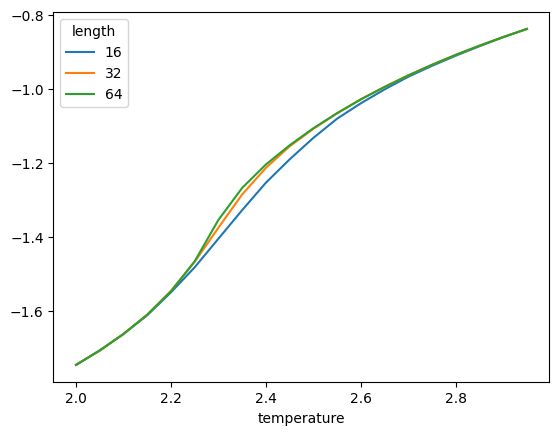

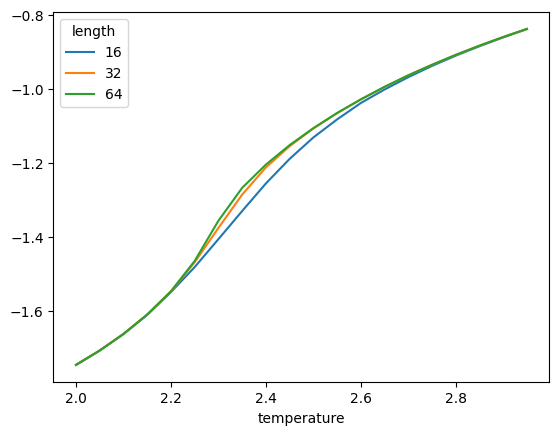

In [7]:
df1 = df.groupby(['name','length','temperature']).agg({'energy1': np.mean}).reset_index()

df2 = df1.assign(E=df1['energy1']/(df1['length']**2))

pd.pivot_table(df2[df1['name']=='C'].reset_index(),
               index='temperature', columns='length', values='E'
              ).plot()

pd.pivot_table(df2[df1['name']=='Numpy'].reset_index(),
               index='temperature', columns='length', values='E'
              ).plot()

<Axes: xlabel='temperature'>

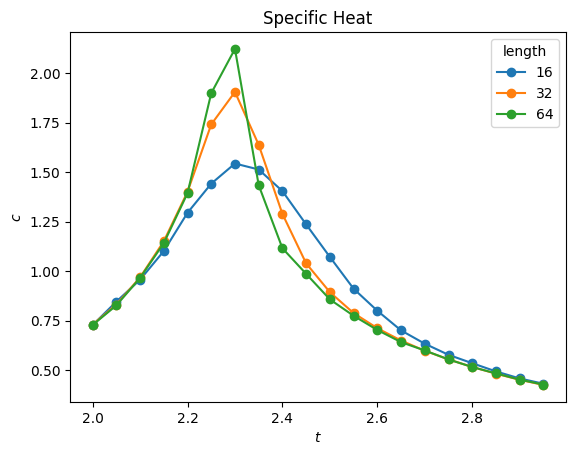

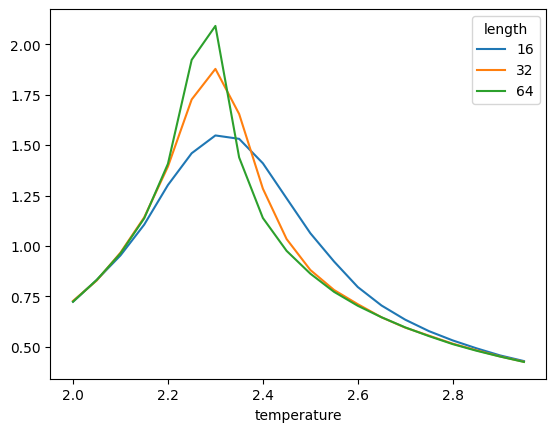

In [8]:
df1 = df.groupby(['name','length','temperature']).agg({'energy1': np.mean, 'energy2': np.mean}).reset_index()

df2 = df1.assign(cv=(df1['energy2']-(df1['energy1']**2))/(df1['length']**2 * df1['temperature']**2))

pd.pivot_table(df2[df2['name']=='C'].reset_index(),
               index='temperature', columns='length', values='cv'
              ).plot(ylabel='$c$', xlabel='$t$', marker='o', title='Specific Heat').get_figure().savefig('specificHeat.png')

pd.pivot_table(df2[df2['name']=='Numpy'].reset_index(),
               index='temperature', columns='length', values='cv'
              ).plot()

<Axes: xlabel='temperature'>

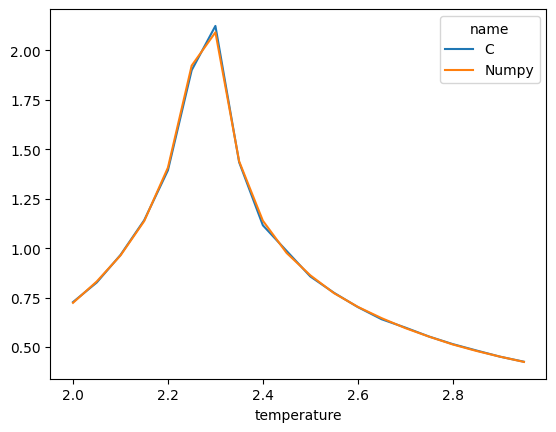

In [9]:
df1 = df.groupby(['name','length','temperature']).agg({'energy1': np.mean, 'energy2': np.mean, 'magnet1': np.mean, 'magnet2': np.mean}).reset_index()

df2 = df1[df1['length']==64].assign(cv=(df1['energy2']-(df1['energy1']**2))/(df1['length']**2 * df1['temperature']**2))

pd.pivot_table(df2.reset_index(),
               index='temperature', columns='name', values='cv'
              ).plot()


<Axes: xlabel='temperature', ylabel='magnetization'>

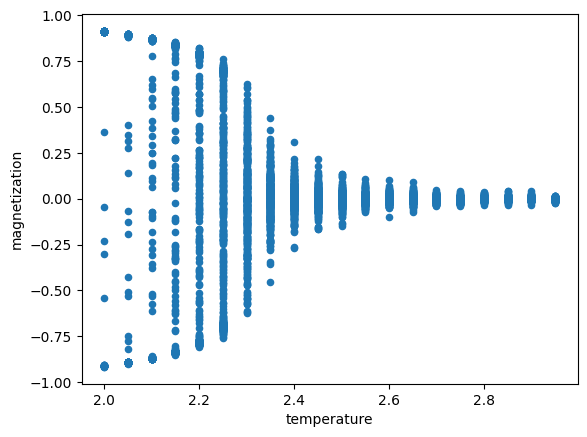

In [10]:
df1 = df.assign(magnetization=df['magnet1']/(df['length']**2) )
df1.plot.scatter(x='temperature', y='magnetization')

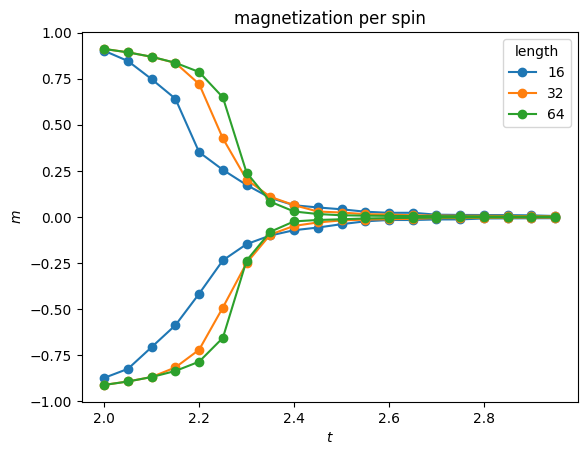

In [11]:
df1 = df[df['magnet1']>0].groupby(['length','temperature']).agg({'magnet1': np.mean}).reset_index()
df2 = df1.assign(magnetization=df1['magnet1']/(df1['length']**2))
pv0 = pd.pivot(df2.reset_index(),index='temperature', columns='length', values='magnetization')

df1 = df[df['magnet1']<0].groupby(['length','temperature']).agg({'magnet1': np.mean}).reset_index()
df2 = df1.assign(magnetization=df1['magnet1']/(df1['length']**2))
pv1 = pd.pivot(df2.reset_index(),index='temperature', columns='length', values='magnetization')

pd.concat([pv0, pv1.iloc[::-1]]).plot(ylabel='$m$', xlabel='$t$', marker='o', title='magnetization per spin').get_figure().savefig('magnetization.png')